In [3]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost shap kagglehub

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import shap

In [7]:
df = pd.read_csv('accepted_2007_to_2018q4.csv', low_memory=False)  
df = df.sample(100000, random_state=42)  # Sample для теста
print(df.head())

df['target'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)
print(df['target'].value_counts(normalize=True))  # Imbalance ~20-30% default

                id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
392949    39651438        NaN    32000.0      32000.0          32000.0   
1273506   16411620        NaN     9600.0       9600.0           9600.0   
324024    45122316        NaN     4000.0       4000.0           4000.0   
2066630  125356772        NaN     6025.0       6025.0           6025.0   
477199   128490686        NaN    25000.0      25000.0          25000.0   

               term  int_rate  installment grade sub_grade  ...  \
392949    60 months     10.49       687.65     B        B3  ...   
1273506   36 months     12.99       323.42     C        C1  ...   
324024    36 months      6.68       122.93     A        A3  ...   
2066630   36 months     10.91       197.00     B        B4  ...   
477199    60 months     26.30       752.96     E        E5  ...   

        hardship_payoff_balance_amount hardship_last_payment_amount  \
392949                             NaN                          NaN   
1273506   

In [8]:
features = ['loan_amnt', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'fico_range_low']
df = df[features + ['target']].dropna()

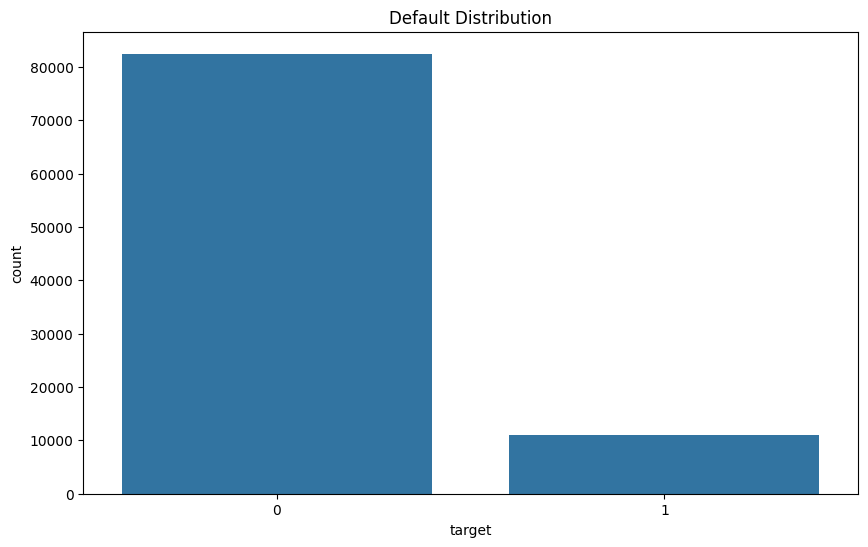

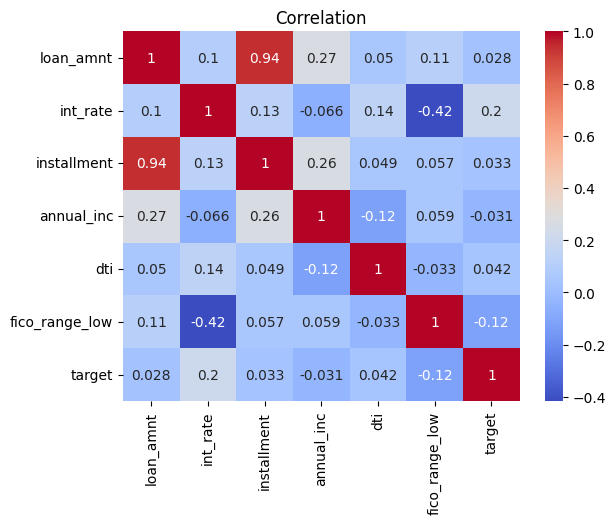

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df)
plt.title('Default Distribution')
plt.show()

num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation')
plt.show()

In [10]:
df['income_log'] = np.log(df['annual_inc'] + 1)  # Log для skew
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)  # Extract numbers

cat_cols = ['grade']
num_cols = [col for col in features if col not in cat_cols]

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/5r/_fpjyd7j4w31rq11_t7wcprm0000gn/T/ipykernel_2167/3037249532.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)  # Extract numbers


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print('Logistic Regression Report:\n', classification_report(y_test, y_pred_lr))
print('AUC:', roc_auc_score(y_test, lr_pipeline.predict_proba(X_test)[:, 1]))

cv_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='roc_auc')
print('CV AUC Mean:', cv_scores.mean())

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, eval_metric='auc'))])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print('XGBoost Report:\n', classification_report(y_test, y_pred_xgb))
print('AUC:', roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1]))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94     16492
           1       0.20      0.00      0.00      2217

    accuracy                           0.88     18709
   macro avg       0.54      0.50      0.47     18709
weighted avg       0.80      0.88      0.83     18709

AUC: 0.6936015012431773
CV AUC Mean: 0.6980151040804744
XGBoost Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94     16492
           1       0.42      0.02      0.03      2217

    accuracy                           0.88     18709
   macro avg       0.65      0.51      0.48     18709
weighted avg       0.83      0.88      0.83     18709

AUC: 0.7138768283491915


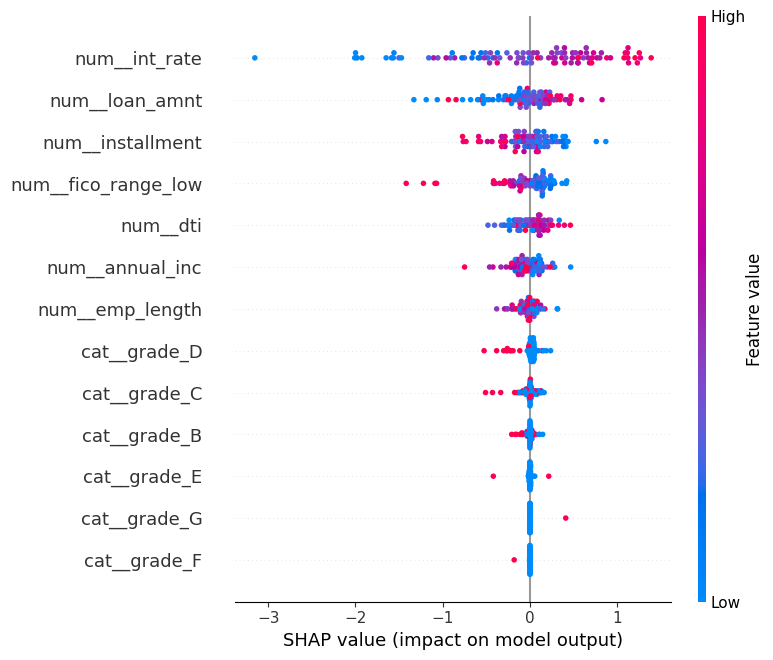

In [13]:
X_test_transformed = xgb_pipeline.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(xgb_pipeline.named_steps['classifier'], X_test_transformed)
shap_values = explainer(X_test_transformed[:100])  # Sample для скорости
shap.summary_plot(shap_values, X_test_transformed[:100], feature_names=preprocessor.get_feature_names_out())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN  # Улучшение: ADASYN for better handling
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import joblib

# 1. Загрузка
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
df = df.sample(100000, random_state=42)

df['target'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

# 2. Extended features (улучшение: more for better AUC)
features = ['loan_amnt', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'fico_range_low', 'term', 'home_ownership', 'verification_status', 'purpose', 'inq_last_6mths', 'revol_util']
df = df[features + ['target']].dropna()  # Dropna, but in prod impute

# 3. EDA (same)
sns.countplot(x='target', data=df)
plt.title('Default Distribution')
plt.savefig('default_dist.png')

num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.savefig('corr_credit.png')

# 4. Feature Eng (add revol_util clean)
df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0 if 'revol_util' in df else df['revol_util']
df['income_log'] = np.log(df['annual_inc'] + 1)
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['term'] = df['term'].str.extract('(\d+)').astype(float)

cat_cols = ['grade', 'home_ownership', 'verification_status', 'purpose']
num_cols = [col for col in df.columns if col not in cat_cols + ['target']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# 5. Split
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. ImbPipeline with ADASYN
pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='auc'))
])

# 7. Extended tuning
scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)
params = {
    'adasyn__sampling_strategy': ['minority', 0.3, 0.5],
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__scale_pos_weight': [scale_pos / 2, scale_pos, scale_pos * 2],
    'classifier__subsample': [0.8, 1.0]
}

grid = GridSearchCV(pipe, params, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

# 8. Evaluation with threshold tuning
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:,1]
prec, rec, thres = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * rec * prec / (rec + prec)
best_thres = thres[np.argmax(f1_scores[:-1])]
y_pred = (y_prob >= best_thres).astype(int)

print('Best Params:', grid.best_params_)
print('Improved v2 XGBoost Report:\n', classification_report(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_prob))
print('AUPRC:', average_precision_score(y_test, y_prob))
print('CV AUC Mean:', cross_val_score(best_model, X, y, cv=5, scoring='roc_auc').mean())
print('Best Threshold:', best_thres)
print('Max F1 at thres:', max(f1_scores[:-1]))

# 9. SHAP (same, save plot)
X_test_trans = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(best_model.named_steps['classifier'], X_test_trans)
shap_values = explainer(X_test_trans[:100])
shap.summary_plot(shap_values, X_test_trans[:100], feature_names=best_model.named_steps['preprocessor'].get_feature_names_out())
plt.savefig('shap_summary.png')
# Save
joblib.dump(best_model, 'credit_model_v2.pkl')

<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
/var/folders/5r/_fpjyd7j4w31rq11_t7wcprm0000gn/T/ipykernel_1377/3091878163.py:39: SyntaxWarning: invalid escape sequence '\d'
  df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
/var/folders/5r/_fpjyd7j4w31rq11_t7wcprm0000gn/T/ipykernel_1377/3091878163.py:40: SyntaxWarning: invalid escape sequence '\d'
  df['term'] = df['term'].str.extract('(\d+)').astype(float)
